In [1]:
import sys
import os

# Manually specify the path to the parent directory
parent_dir = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/code_base'  # Replace this with the path where 'Pipelines' is located
sys.path.append(parent_dir)

from Pipelines.vision_pipeline import vision_pipeline
from Pipelines.ocr_processor import OCRProcessor
import cv2
import pytesseract
from pytesseract import Output
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Loading Vision Model...
Model loaded successfully.


0: 800x1024 10 grade headerss, 5 grade tables, 5 singe row tables, 188.4ms
Speed: 7.7ms preprocess, 188.4ms inference, 8.3ms postprocess per image at shape (1, 3, 800, 1024)


Image path: /Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/2015-queens-university-transcript-1-2048.webp


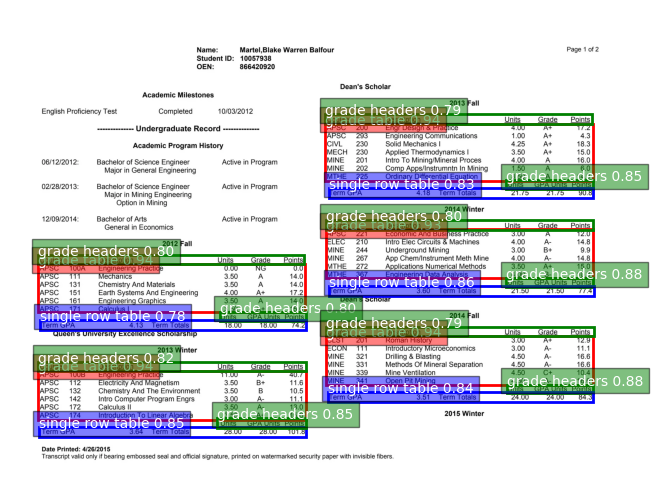

In [2]:
image_directory = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/'
image_name = '2015-queens-university-transcript-1-2048.webp'
image_path = image_directory + image_name

model_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/code_base/yolo_training/yolo_v8_models/finetune_v5/best.pt'
pipeline = vision_pipeline(model_path)
results = pipeline.predict(image_path, plot = True, iou = 0.3, conf = 0.5, agnostic_nms = True)

In [22]:
ocr_processor = OCRProcessor()

processed_results = ocr_processor.process_images_with_ocr(results, image_path, use_tesseract=True)
formatted_strings = ocr_processor.format_strings(processed_results)

first_image_name = next(iter(formatted_strings))
print(formatted_strings[first_image_name]['header_data'])
print(formatted_strings[first_image_name]['table_data'])

Units GPA Units Points.
Units GPA Units Points
Units GPA Units Points
Units GPA Units Points.
Course Description Units Grade _— Points
Course Description Units Grade Points
Units GPA Units Points
Course Description Units Grade Points
Course Description Units Grade Points
Course Description Units Grade Points
APSC 200 Engr Design & Practice 4.00 At 17.2
APSC 293 Engineering Communications 1.00 At 4.3
CIVL 230 Solid Mechanics | 4.25 At 18.3
MECH 230 Applied Thermodynamics | 3.50 At 15.0
MINE 201 Intro To Mining/Mineral Proces 4.00 A 16.0
MINE 202 Comp Apps/Instrumntn In Mining 1.50 A 6.0
MTHE 225 Ordinary Differential Equation 3.50 A 14.0
APSC 100A Engineering Practice 0.00 NG 0.0
APSC 111 Mechanics 3.50 A 14.0
APSC 131 Chemistry And Materials 3.50 A 14.0
APSC 151 Earth Systems And Engineering 4.00 At 17.2
APSC 161 Engineering Graphics 3.50 A 14.0
APSGC 171 Calculus | 3.50 At 15.0
CLST 201 Roman History 3.00 At 12.9
ECON 111 Introductory Microeconomics 3.00 A- 11.1
MINE 321 Drilling & Bl

In [3]:
image_name = os.path.basename(image_path)
image = cv2.imread(image_path)

if image is None:
    print(f"Failed to load image from {image_path}.")

result = results[0]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes = result.boxes.data.cpu().numpy()
classes = result.boxes.cls.cpu().numpy()

cropped_images = []
dicts = [] # List of dictionaries
for idx, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box[:4])
    cropped_image = Image.fromarray(image_rgb[y1:y2, x1:x2])
    cropped_images.append(cropped_image)
    d = pytesseract.image_to_data(cropped_image, output_type=Output.DICT, config = '--psm 6')
    dicts.append(d)

In [90]:
""" For Grouping Tables with Headers.
"""
def is_directly_above(header, table, threshold=10):
    header_bottom = header['box'][3]  # y2 value of header box
    table_top = table['box'][1]       # y1 value of table box

    return abs(header_bottom - table_top) <= threshold

headers = []
tables = []
single_row = []

for idx, box in enumerate(boxes):
    class_type = classes[idx]
    text = pytesseract.image_to_data(cropped_images[idx], output_type=Output.DICT, config = '--psm 6')
    if class_type == 0:
        headers.append({'box': box, 'text': text})
    elif class_type == 1:
        tables.append({'box': box, 'text': text})
    else:
        single_row.append({'box': box, 'text': text})

matched_pairs = []
for header in headers:
    for table in tables:
        if is_directly_above(header, table):
            matched_pairs.append((header, table))

def separate_columns(header, table):
    columns = []
    # Assuming header['text'] contains positions for each column header
    for col_header in header['text']['text']:
        if col_header.strip():  # Ensure the header text is not empty
            col_index = header['text']['text'].index(col_header)
            x_start = header['text']['left'][col_index]
            x_end = x_start + header['text']['width'][col_index]
            columns.append((x_start, x_end))
            print(f"Column '{col_header}' from x={x_start} to x={x_end}")  # Debugging output

    table_data = [[] for _ in range(len(columns))]  # Pre-allocate lists based on number of columns

    for i, text in enumerate(table['text']['text']):
        if text.strip():
            x_pos = table['text']['left'][i]
            added_to_column = False
            for j, (start, end) in enumerate(columns):
                if start <= x_pos < end:
                    table_data[j].append(text)
                    added_to_column = True
                    break
            if not added_to_column:
                print(f"Text '{text}' at x={x_pos} could not be placed in any column.")  # Debugging output

    return table_data


for header, table in matched_pairs:
    structured_data = separate_columns(header, table)
    print(structured_data)  # or store/return it as needed

Column 'Course' from x=7 to x=80
Column 'Description' from x=202 to x=315
Column 'Units' from x=595 to x=646
Column 'Grade' from x=705 to x=768
Column '_—' from x=785 to x=808
Column 'Points' from x=813 to x=875
Text 'APSC' at x=6 could not be placed in any column.
Text ' 100B' at x=105 could not be placed in any column.
Text 'Practice' at x=332 could not be placed in any column.
Text 'APSC' at x=6 could not be placed in any column.
Text '112' at x=105 could not be placed in any column.
Text 'Magnetism' at x=355 could not be placed in any column.
Text 'APSC' at x=6 could not be placed in any column.
Text '132' at x=105 could not be placed in any column.
Text 'Chemistry' at x=201 could not be placed in any column.
Text 'The' at x=359 could not be placed in any column.
Text 'Environment' at x=407 could not be placed in any column.
Text 'APSC' at x=6 could not be placed in any column.
Text '142' at x=105 could not be placed in any column.
Text 'Program' at x=363 could not be placed in any

In [171]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

image_name = os.path.basename(image_path)
image = cv2.imread(image_path)

if image is None:
    print(f"Failed to load image from {image_path}.")

result = results[0]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes = result.boxes.data.cpu().numpy()
classes = result.boxes.cls.cpu().numpy()

cropped_images = []
dicts = [] # List of dictionaries

for idx, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box[:4])
    cropped_image = Image.fromarray(image_rgb[y1:y2, x1:x2])
    cropped_images.append(cropped_image)
    d = pytesseract.image_to_data(cropped_image, output_type=Output.DICT, config = '--psm 6')
    dicts.append(d)

headers = []
tables = []
single_row = []

# Group bounding boxes by class
for idx, box in enumerate(boxes):
    class_type = classes[idx]
    text = pytesseract.image_to_data(cropped_images[idx], output_type=Output.DICT, config = '--psm 6')
    if class_type == 0:
        headers.append({'box': box, 'text': text})
    elif class_type == 1:
        tables.append({'box': box, 'text': text})
    else:
        single_row.append({'box': box, 'text': text})

def extract_horizontal_positions(tables):
    positions = []
    texts = []
    y_positions = []  # To store the y positions for plotting

    for table in tables:
        for i, text in enumerate(table['text']['text']):
            if text.strip():  # Filter out empty strings
                x1 = table['text']['left'][i]
                width = table['text']['width'][i]
                y1 = table['text']['top'][i]  # Capture the top y-coordinate
                x2 = x1 + width
                height = table['text']['height'][i]  # Capture the height

                positions.append([x1, x2])
                texts.append(text)
                y_positions.append((y1, height))  # Store as a tuple of top and height

    return np.array(positions), texts, y_positions

positions, texts, y_positions = extract_horizontal_positions([tables[1]])


def custom_distance(u, v):
    # u and v are arrays [x1, x2]
    # Adjusted to be more sensitive to smaller gaps
    min_left_dist = min(abs(v[0] - u[1]), abs(v[0] - u[0]))
    min_right_dist = min(abs(v[1] - u[1]), abs(v[1] - u[0]))
    dist = min (min_left_dist, min_right_dist)
    return dist

# Compute the distance matrix using the custom function
distance_matrix = pairwise_distances(positions, metric=custom_distance)

# Apply DBSCAN
eps = 30
dbscan = DBSCAN(eps=eps, min_samples=1, metric="precomputed")  # eps can be adjusted based on expected gaps\

labels = dbscan.fit_predict(distance_matrix)

print("Cluster Labels:", labels)

Cluster Labels: [0 1 2 2 3 4 5 0 1 2 3 4 5 0 1 2 2 2 3 4 5 0 1 2 2 2 2 3 4 5 0 1 2 2 3 4 5 0 1 2 2 3 4 5]


In [172]:
def assign_to_columns(texts, labels):
    columns = {}
    for label, text in zip(labels, texts):
        if label not in columns:
            columns[label] = []
        columns[label].append(text)
    return columns

columns = assign_to_columns(texts, labels)
print(columns)

{0: ['APSC', 'APSC', 'APSC', 'APSC', 'APSC', 'APSGC'], 1: ['100A', '111', '131', '151', '161', '171'], 2: ['Engineering', 'Practice', 'Mechanics', 'Chemistry', 'And', 'Materials', 'Earth', 'Systems', 'And', 'Engineering', 'Engineering', 'Graphics', 'Calculus', '|'], 3: ['0.00', '3.50', '3.50', '4.00', '3.50', '3.50'], 4: ['NG', 'A', 'A', 'At', 'A', 'At'], 5: ['0.0', '14.0', '14.0', '17.2', '14.0', '15.0']}


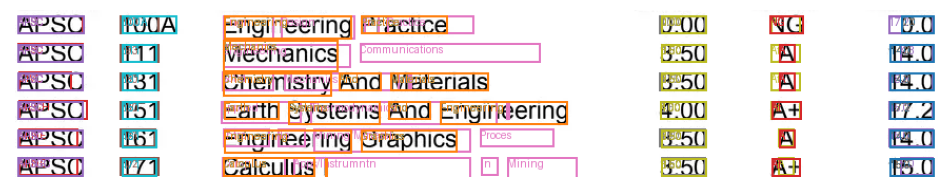

In [173]:
from PIL import ImageDraw
import matplotlib.colors as mcolors
import random

# Load the original image
image = cropped_images[1]
# Assuming 'image' is the main document image loaded from `image_path`
draw = ImageDraw.Draw(image)

# Define colors for clusters, assuming `labels` array exists from clustering
colors = list(mcolors.TABLEAU_COLORS.values())
random.shuffle(colors)

for (pos, text, label, y_pos) in zip(positions, texts, labels, y_positions):
    x1, x2 = pos
    y1, height = y_pos
    y2 = y1 + height
    color = colors[label % len(colors)]

    # Draw rectangle
    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
    # Optionally, add text
    draw.text((x1, y1), text, fill=color)

# Show the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

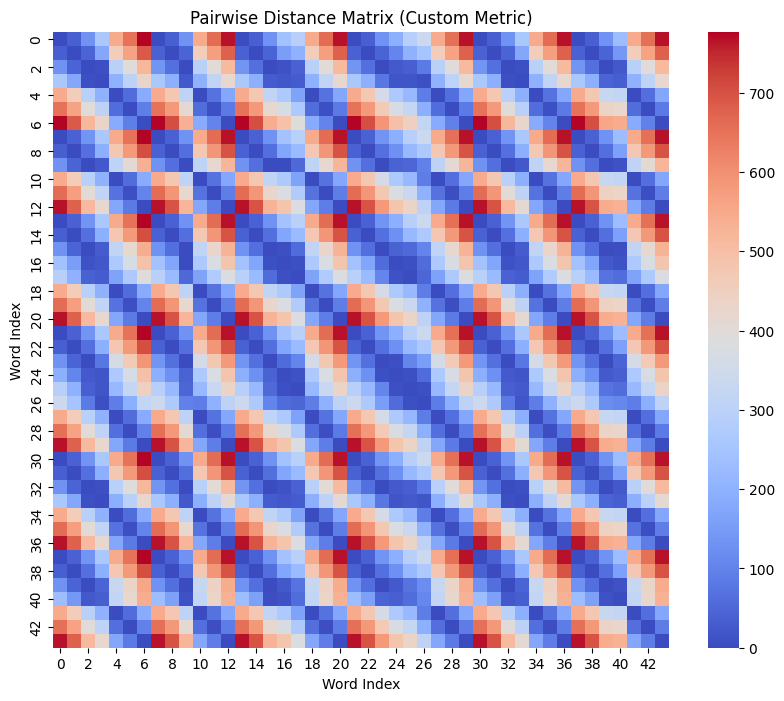

In [187]:
import seaborn as sns
# Plotting the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Pairwise Distance Matrix (Custom Metric)")
plt.xlabel("Word Index")
plt.ylabel("Word Index")
plt.show()

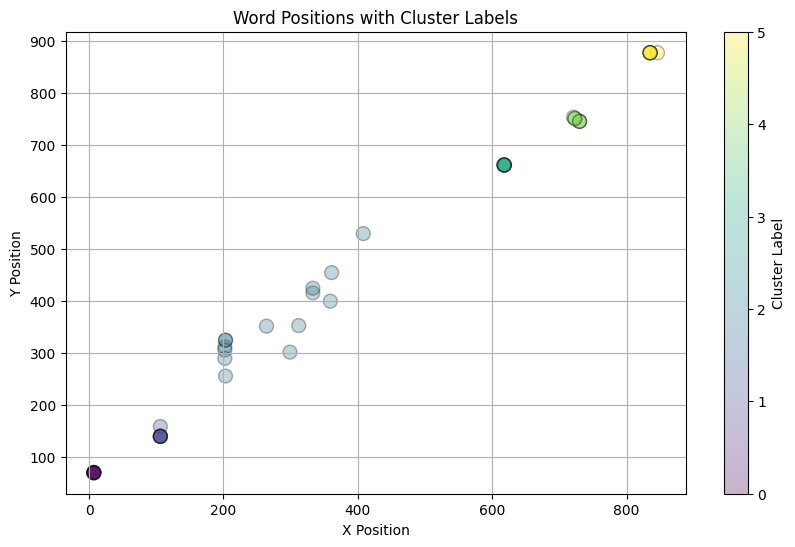

In [182]:
def plot_word_positions_2d(positions, labels):
    """
    Plots a scatter plot of word positions with different colors for different clusters.
    
    Args:
    - positions (np.ndarray): An array of positions where each row is [x_center, y_center].
    - labels (list or np.ndarray): Cluster labels for each position.
    
    Returns:
    - A scatter plot showing the word positions colored by their cluster label.
    """
    # Convert labels to numpy array to ensure it's in the correct format
    labels = np.asarray(labels)

    # Check if the sizes of positions and labels match
    if len(positions) != len(labels):
        raise ValueError("The length of positions must be equal to the length of labels.")

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(positions[:, 0], positions[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.3, s=100)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('Word Positions with Cluster Labels')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.show()

# print(positions, labels)
plot_word_positions_2d(positions, labels)


In [147]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

def calculate_clustering_metrics(positions, labels):

    # Assuming 'X' is the dataset and 'labels' are the labels from DBSCAN
    sil_score = silhouette_score(positions, labels)

    db_index = davies_bouldin_score(positions, labels)

    ch_index = calinski_harabasz_score(positions, labels)

    print("Silhouette Score: ", sil_score)
    print("Davies-Bouldin Index: ", db_index)
    print("Calinski-Harabasz Index: ", ch_index)
print("""
Criteria:
        HIGH Silhouette Score
        LOW Davies-Bouldin Index
        HIGH Calinski-Haravasz Index
      """)
# 60 = Bad
# 52 = OK
# 40 = OK
# 30 = What we want/Good Seperation
print("EPS:", eps)
calculate_clustering_metrics(positions, labels)


Criteria:
        HIGH Silhouette Score
        LOW Davies-Bouldin Index
        HIGH Calinski-Haravasz Index
      
EPS: 30
Silhouette Score:  0.689641334915855
Davies-Bouldin Index:  0.29393355790343706
Calinski-Harabasz Index:  210.22344655805557


In [143]:
print("EPS: ", eps)
calculate_clustering_metrics(positions, labels)

EPS:  40
Silhouette Score:  0.6958030452664672
Davies-Bouldin Index:  0.33400859400780636
Calinski-Harabasz Index:  236.57276473845732


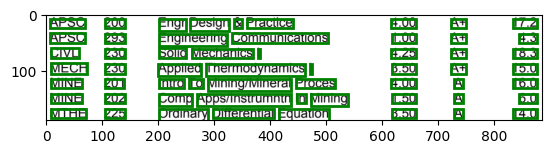

In [89]:


# Configuration and data loading
conf = 0.8
group = 1
d = dicts[group]
image = cropped_images[group]
n_boxes = len(d['text'])

# Create a figure and axis for drawing
fig, ax = plt.subplots(1)
ax.imshow(image)

# Drawing rectangles based on confidence and box data
for i in range(n_boxes):
    if int(d['conf'][i]) > conf*10:
        # print(d['conf'][i])
        x, y, w, h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    else:
        continue

# Display the image with rectangles
plt.show()

In [64]:
# d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d["text"])
print(d["left"])

['', '', '', '', 'Course', 'Description', 'Units', 'Grade', 'Points']
[0, 7, 7, 7, 7, 201, 594, 704, 813]


In [2]:

# Example usage
headers = """Course Description Units Grade _— Points
Course Description Units Grade Points
Course Description Units Grade Points
Course Description Units Grade _— Points
Course Description Units Grade Points
"""

text = """APSC 221 Economic And Business Practice 3.00 A 12.0
ELEC 210 Intro Elec Circuits & Machines 4.00 A- 14.8
MINE 244 Underground Mining 3.00 Bt 9.9
MINE 267 App Chem/Instrument Meth Mine 4.00 A- 14.8
MTHE 272 Applications Numerical Methods. 3.50 At 15.0
MTHE 367 Engineering Data Analysis 4.00 B- 10.8
APSC 100A Engineering Practice 0.00 NG 0.0
APSC 111 Mechanics 3.50 A 14.0
APSC 131 Chemistry And Materials 3.50 A 14.0
APSC 151 Earth Systems And Engineering 4.00 At 17.2
APSC 161 Engineering Graphics 3.50 A 14.0
APSC 171 Calculus | 3.50 At 15.0
APSC 200 Engr Design & Practice 4.00 At 17.2
APSC 293 Engineering Communications 1.00 At 4.
CIVL 230 Solid Mechanics | 4.25 At 18.
MECH 230 Applied Thermodynamics | 3.50 At 15.(
MINE 201 Intro To Mining/Mineral Proces 4.00 A 16.(
MINE 202 Comp Apps/Instrumntn In Mining 1.50 A 6.(
MTHE 225 Ordinary Differential Equation 3.50 A 14.(
APSC  100B Engineering Practice 11.00 A- 40.7
APSC 112 Electricity And Magnetism 3.50 B+ 11.6
APSC 132 Chemistry And The Environment 3.50 B 10.5
APSC 142 Intro Computer Program Engrs 3.00 A- 11.1
APSC_ 172 Calculus II 3.50 A- 13.0
APSC 174 Introduction To Linear Algebra 3.50 At 15.0
CLST 201 Roman History 3.00 At 12.¢
ECON 111 Introductory Microeconomics 3.00 A- 11.1
MINE 321 Drilling & Blasting 4.50 A- 16.6
MINE 331 Methods Of Mineral Separation 4.50 A- 16.€
MINE 339 Mine Ventilation 4.50 Ct 10.4
MINE 341 Open Pit Mining 4.50 A- 16.6
Academic Program History
06/12/2012: Bachelor of Science Engineer Active in Program
Major in General Engineering
02/28/2013: Bachelor of Science Engineer Active in Program
Major in Mining Engineering
Option in Mining
12/09/2014: Bachelor of Arts Active in Program
Term GPA 3.51. Term Totals 24.00 24.00 84.3
Term GPA 3.60 Term Totals 21.50 21.50 774
Term GPA 4.18 Term Totals 21.75 21.75 90.8
Term GPA 3.64 Term Totals 28.00 28.00 101.8
Term GPA 4.13 Term Totals 18.00 18.00 74.2
"""

df = process_text_to_csv(text)
df.to_csv('output.csv', index=False)
print("CSV file has been created.")

/Users/declanbracken/Development/UofT_Projects/Meng_Project/code_base/yolo_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: 5 columns passed, passed data had 10 columns